This notebook is used to investigate how the change in params works with andes and the itm_step function.

In [68]:
import sys
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Move one level higher
sys.path.append(str(Path.cwd().parents[0]))
import andes as ad
from andes.routines.tds import TDS

# Set plotter use
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.close('all')


In [87]:
# Load system
system = ad.load(ad.get_case("kundur/kundur_full.xlsx"), setup=True)
system.files.no_output = True

# system.add("Toggle", dict(model='PQ', dev="PQ_0", t=1.0))
# system.setup()
# system.Toggle.as_df()

system.PQ.config.p2p = 1.0
system.PQ.config.p2i = 0.0
system.PQ.config.p2z = 0.0
system.PQ.config.q2q = 1.0
system.PQ.config.q2i = 0.0
system.PQ.config.q2z = 0.0
system.PQ.pq2z = 0

system.PFlow.run()

# TDS setup
tds = TDS(system)
tds.config.fixt = 1
tds.config.shrinkt = 0
tds.config.tstep = 0.1
tds.t = 0.0
tds.init()

# Logging
time_history = []
omega_history = [[] for _ in range(len(system.GENROU))]
tm_history = [[] for _ in range(len(system.GENROU))]
tm0_history = [[] for _ in range(len(system.GENROU))]
Pe_history = [[] for _ in range(len(system.GENROU))]
paux0_history = [[] for _ in range(len(system.GENROU))]
paux_history = [[] for _ in range(len(system.GENROU))]
pref_history = [[] for _ in range(len(system.GENROU))]
pref0_history = [[] for _ in range(len(system.GENROU))]
delta_history = [[] for _ in range(len(system.GENROU))]
theta_history = [[] for _ in range(len(system.Bus))]
v_history = [[] for _ in range(len(system.Bus))]
pout_history = [[] for _ in range(len(system.TGOV1))]
pref_plus_paux_history = [[] for _ in range(len(system.TGOV1))]
ppf_history = [[] for _ in range(len(system.PQ))]
pq_history = [[] for _ in range(len(system.PQ))]
pload_history = [[] for _ in range(len(system.PQ))]

Simulation finished.


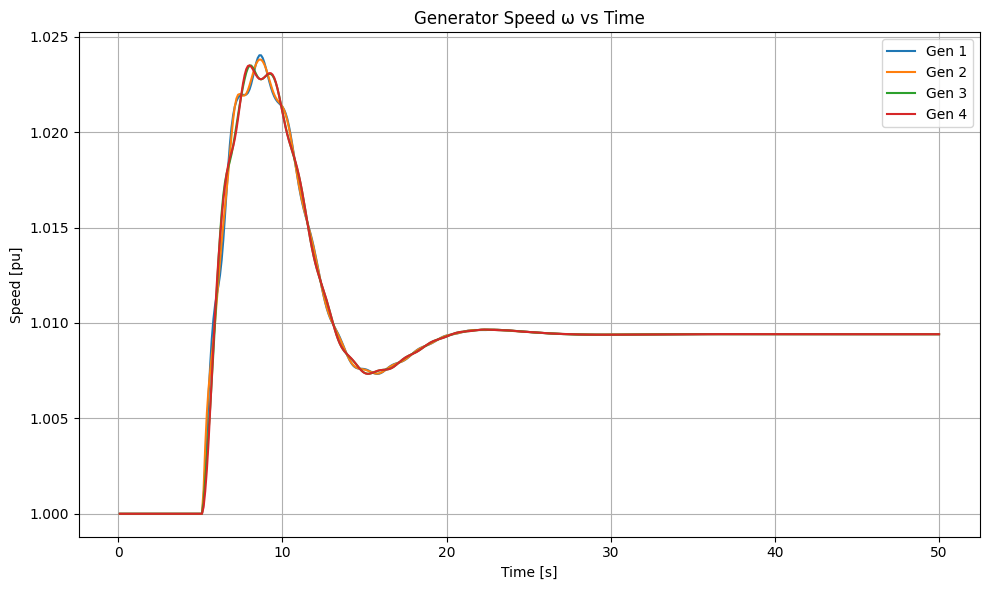

In [88]:
###################### TDS_step test ######################
# tds.config.tf = 0.0 
tds.config.tf = 50.0
one = True

while tds.t < tds.config.tf:

    if tds.t > 5.0 and one == True:
        system.PQ.set(src='Ppf', idx='PQ_0', attr='v', value=5.0)
        # system.TGOV1.set(src='paux0', idx=1, attr='v', value=-0.5)
        one = False
    
    tds.itm_step()
    tds.t += tds.config.tstep

    # Log current state
    time_history.append(tds.t)
    for i in range(len(system.GENROU)):
        omega_history[i].append(system.GENROU.omega.v[i])
        tm_history[i].append(system.GENROU.tm.v[i])
        tm0_history[i].append(system.GENROU.tm0.v[i])
        Pe_history[i].append(system.GENROU.Pe.v[i])
        delta_history[i].append(system.GENROU.delta.v[i])
        paux0_history[i].append(system.TGOV1.paux0.v[i])
        paux_history[i].append(system.TGOV1.paux.v[i])
        pref_history[i].append(system.TGOV1.pref.v[i])
        pref0_history[i].append(system.TGOV1.pref0.v[i])
        pout_history[i].append(system.TGOV1.pout.v[i])
        pref_plus_paux_history[i].append(system.TGOV1.pref.v[i] + system.TGOV1.paux0.v[i])
    for i in range(len(system.PQ)):
        ppf_history[i].append(system.PQ.Ppf.v[i])
        pq_history[i].append(system.PQ.p0.v[i])
    for i in range(len(system.Bus)):
        theta_history[i].append(system.Bus.a.v[i])
        v_history[i].append(system.Bus.v.v[i])
    for i in range(len(system.PQ)):
        v = system.Bus.v.v[system.PQ.bus.v[i]]
        u = 1.0  # assuming enabled, no dynamic switching
        p2p = system.PQ.config.p2p
        p2i = system.PQ.config.p2i
        p2z = system.PQ.config.p2z
        Ppf = system.PQ.Ppf.v[i]
        Ipeq = system.PQ.Ipeq.v[i]
        Req = system.PQ.Req.v[i]

        pload = u * (p2p * Ppf + p2i * Ipeq * v + p2z * Req * v**2)
        pload_history[i].append(pload)

print("Simulation finished.")

# Plot
plt.figure(figsize=(10, 6))
for i, omega in enumerate(omega_history):
    plt.plot(time_history, omega, label=f'Gen {i+1}')
plt.xlabel("Time [s]")
plt.ylabel("Speed [pu]")
plt.title("Generator Speed ω vs Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


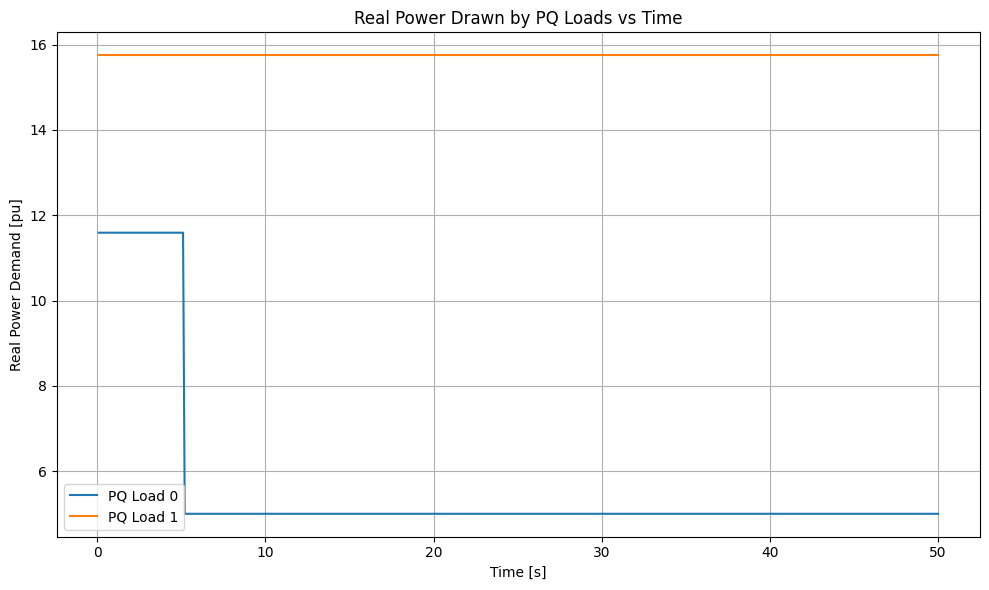

In [89]:
plt.figure(figsize=(10, 6))
for i, pload in enumerate(pload_history):
    plt.plot(time_history, pload, label=f'PQ Load {i}')
plt.xlabel("Time [s]")
plt.ylabel("Real Power Demand [pu]")
plt.title("Real Power Drawn by PQ Loads vs Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

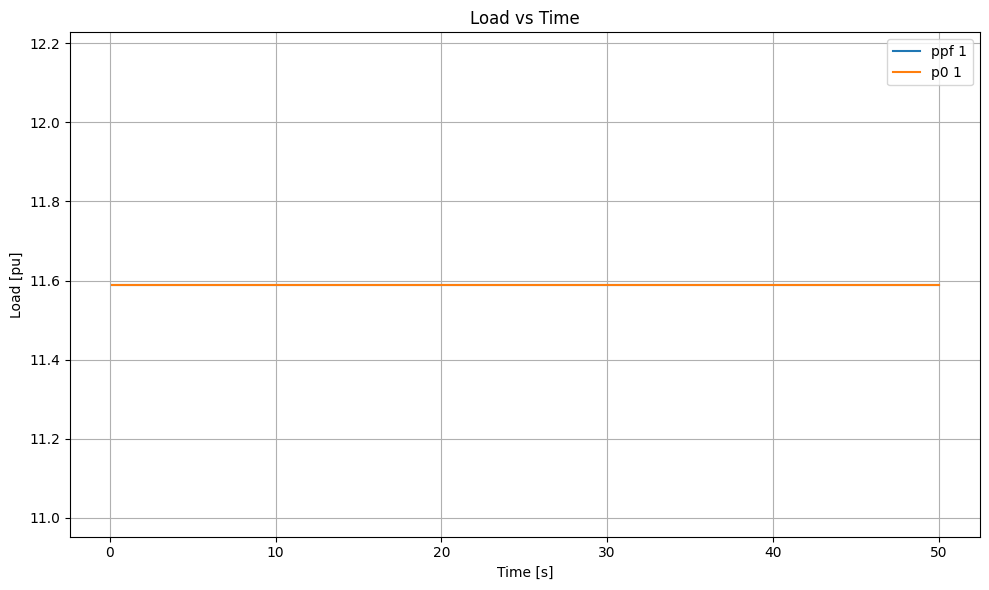

In [71]:
pq_idx = 0
plt.figure(figsize=(10, 6))
plt.plot(time_history, ppf_history[pq_idx], label=f'ppf {pq_idx+1}', linestyle='-')
plt.plot(time_history[:len(pq_history[pq_idx])], pq_history[pq_idx], label=f'p0 {pq_idx+1}', linestyle='-')
plt.xlabel("Time [s]")
plt.ylabel("Load [pu]")
plt.title("Load vs Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show() 

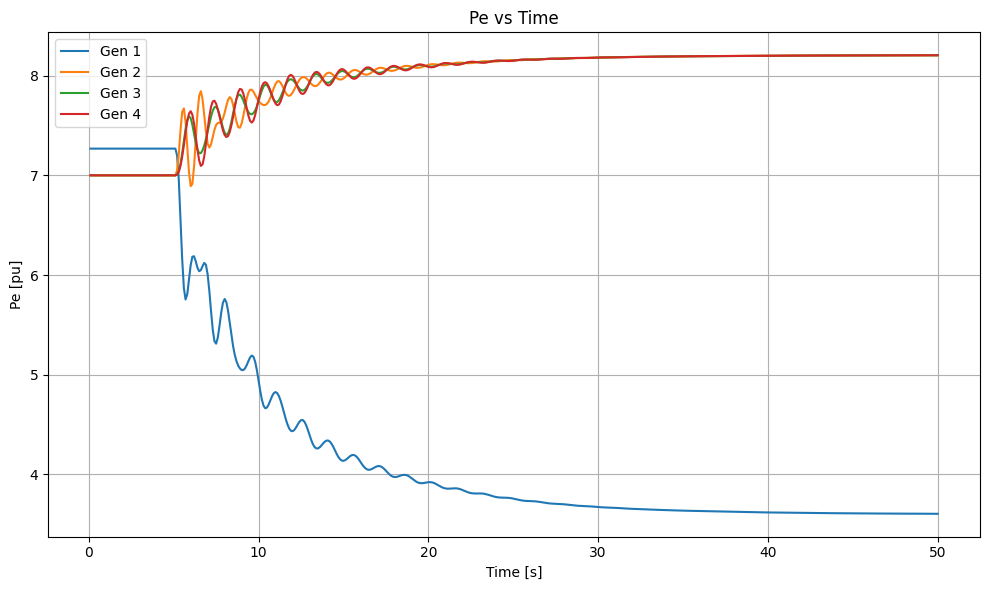

In [72]:
# Plot
plt.figure(figsize=(10, 6))
for i, Pe in enumerate(Pe_history):
    plt.plot(time_history, Pe, label=f'Gen {i+1}')
plt.xlabel("Time [s]")
plt.ylabel("Pe [pu]")
plt.title("Pe vs Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

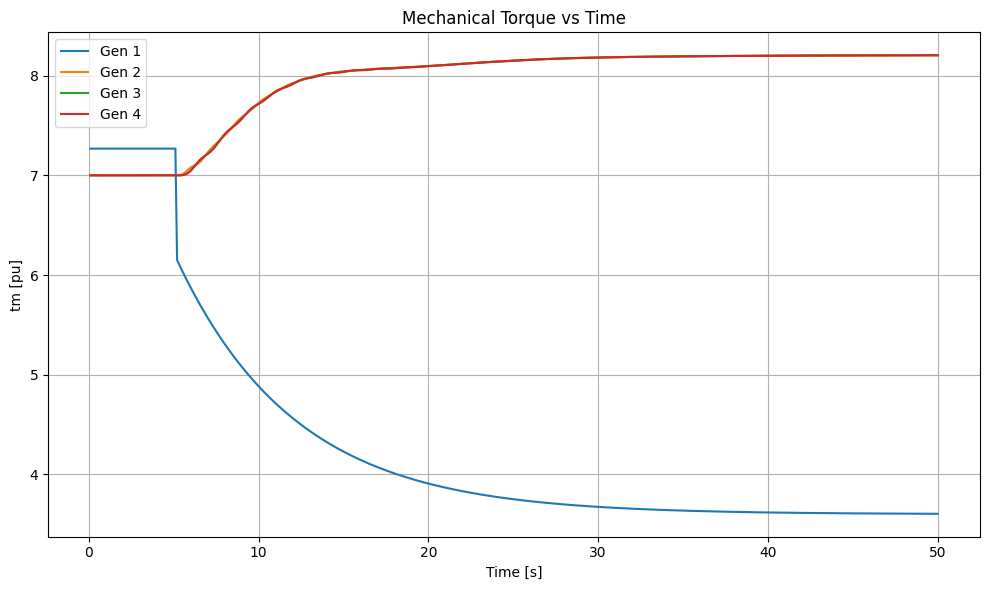

In [73]:
# Plot
plt.figure(figsize=(10, 6))
for i, tm in enumerate(tm_history):
    plt.plot(time_history, tm, label=f'Gen {i+1}')
plt.xlabel("Time [s]")
plt.ylabel("tm [pu]")
plt.title("Mechanical Torque vs Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

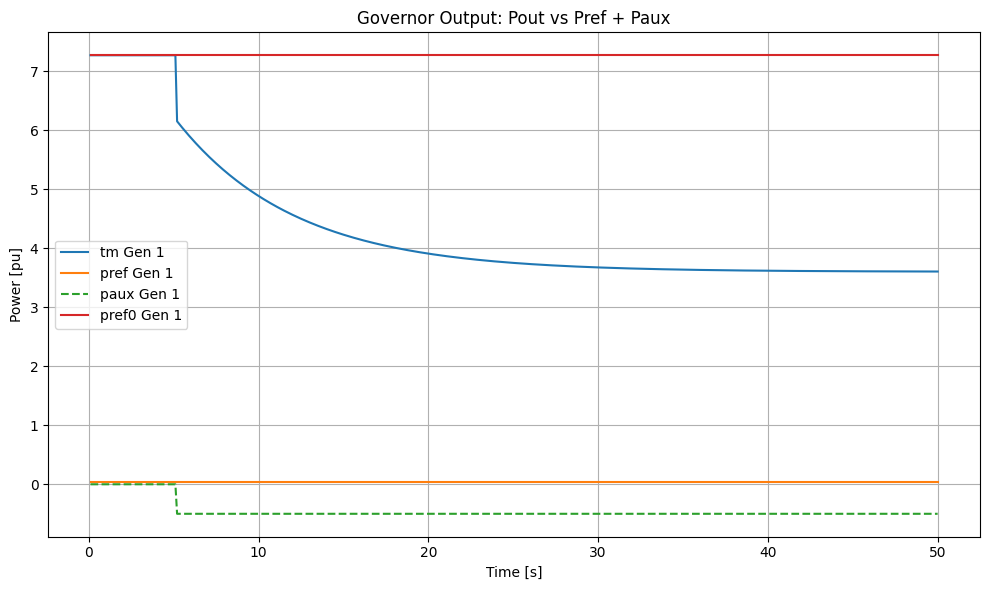

In [74]:
# Plot Pref + Paux vs Pout
gen_idx = 0  # Index of the generator to plot

# Fix the math: convert lists to NumPy arrays
pref_plus_paux = np.array(pref_plus_paux_history[gen_idx])
omega = np.array(omega_history[gen_idx])
R = system.TGOV1.R.v[gen_idx]  # Use lowercase `r` for droop in ANDES

# estimated_pout = (pref_plus_paux - (omega - 1)) / R

plt.figure(figsize=(10, 6))
plt.plot(time_history, tm_history[gen_idx], label=f'tm Gen {gen_idx+1}', linestyle='-')
plt.plot(time_history, pref_history[gen_idx], label=f'pref Gen {gen_idx+1}', linestyle='-')
plt.plot(time_history, paux_history[gen_idx], label=f'paux Gen {gen_idx+1}', linestyle='--')
plt.plot(time_history, pref0_history[gen_idx], label=f'pref0 Gen {gen_idx+1}', linestyle='-')
# plt.plot(time_history, estimated_pout, label=f'estimated Gen {gen_idx+1}', linestyle='-')
plt.xlabel("Time [s]")
plt.ylabel("Power [pu]")
plt.title("Governor Output: Pout vs Pref + Paux")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()  

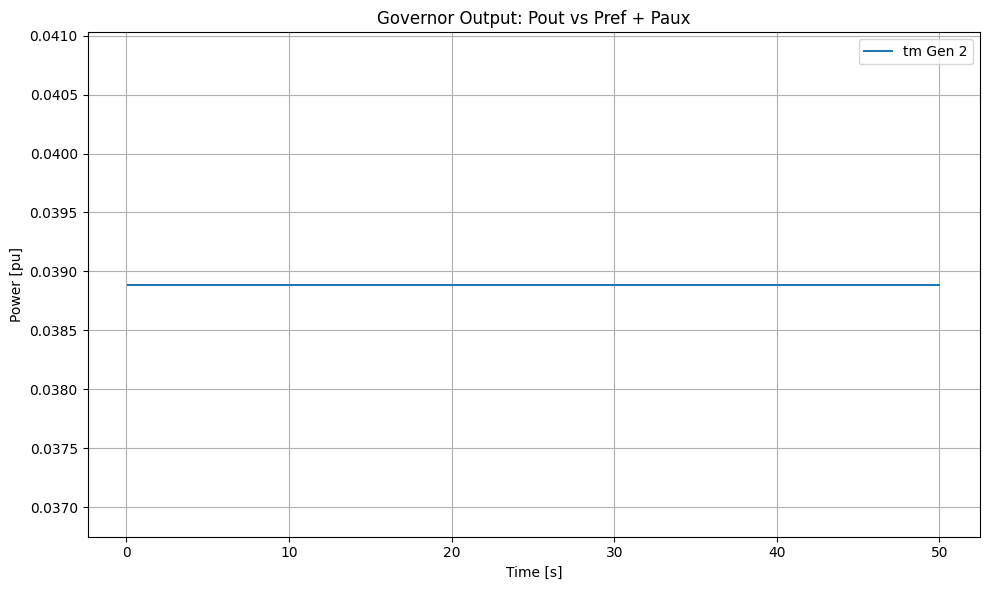

In [75]:
gen_idx = 1 

plt.figure(figsize=(10, 6))
plt.plot(time_history, pref_history[gen_idx], label=f'tm Gen {gen_idx+1}', linestyle='-')
plt.xlabel("Time [s]")
plt.ylabel("Power [pu]")
plt.title("Governor Output: Pout vs Pref + Paux")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()  

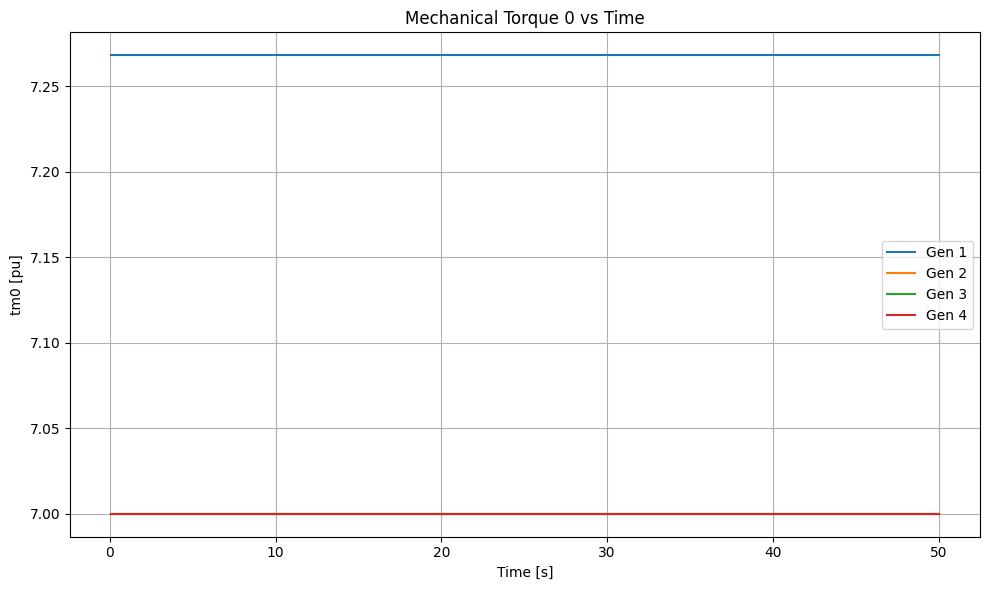

In [76]:
# Plot
plt.figure(figsize=(10, 6))
for i, tm0 in enumerate(tm0_history):
    plt.plot(time_history, tm0, label=f'Gen {i+1}')
plt.xlabel("Time [s]")
plt.ylabel("tm0 [pu]")
plt.title("Mechanical Torque 0 vs Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

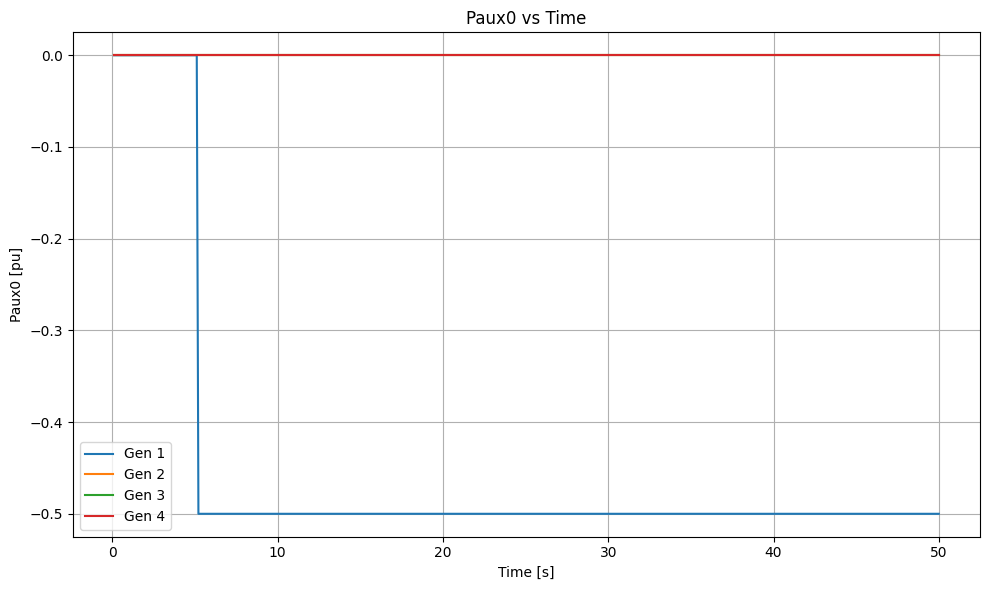

In [77]:
# Plot
plt.figure(figsize=(10, 6))
for i, paux0 in enumerate(paux0_history):
    plt.plot(time_history, paux0, label=f'Gen {i+1}')
plt.xlabel("Time [s]")
plt.ylabel("Paux0 [pu]")
plt.title("Paux0 vs Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

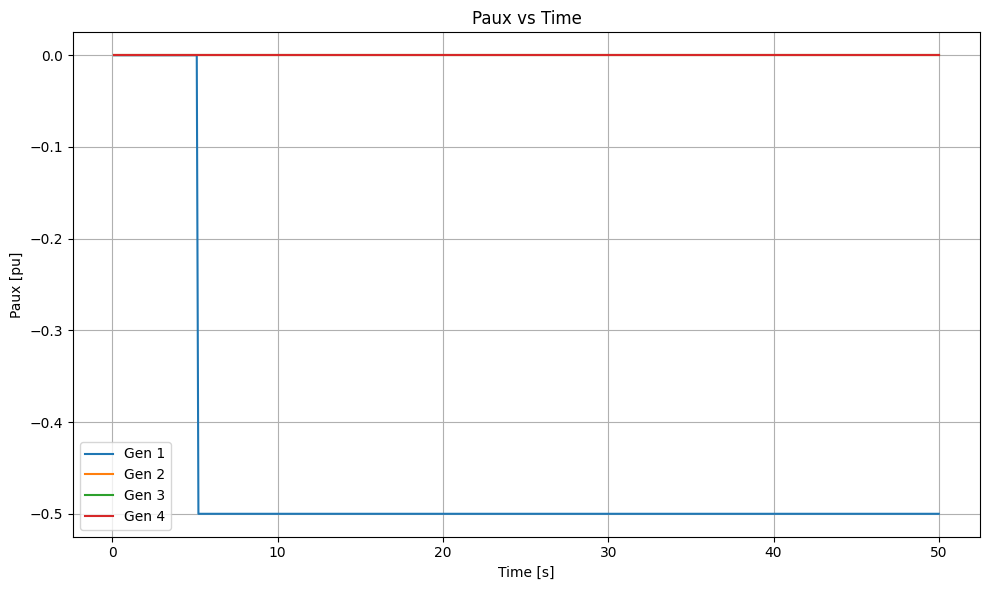

In [78]:
# Plot
plt.figure(figsize=(10, 6))
for i, paux in enumerate(paux_history):
    plt.plot(time_history, paux, label=f'Gen {i+1}')
plt.xlabel("Time [s]")
plt.ylabel("Paux [pu]")
plt.title("Paux vs Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

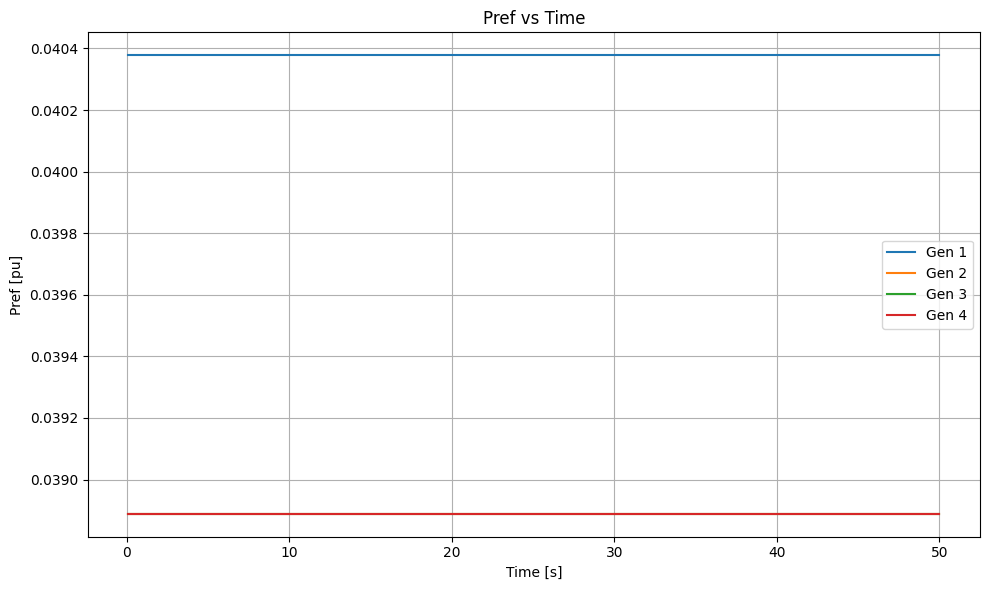

In [79]:
# Plot
plt.figure(figsize=(10, 6))
for i, pref in enumerate(pref_history):
    plt.plot(time_history, pref, label=f'Gen {i+1}')
plt.xlabel("Time [s]")
plt.ylabel("Pref [pu]")
plt.title("Pref vs Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

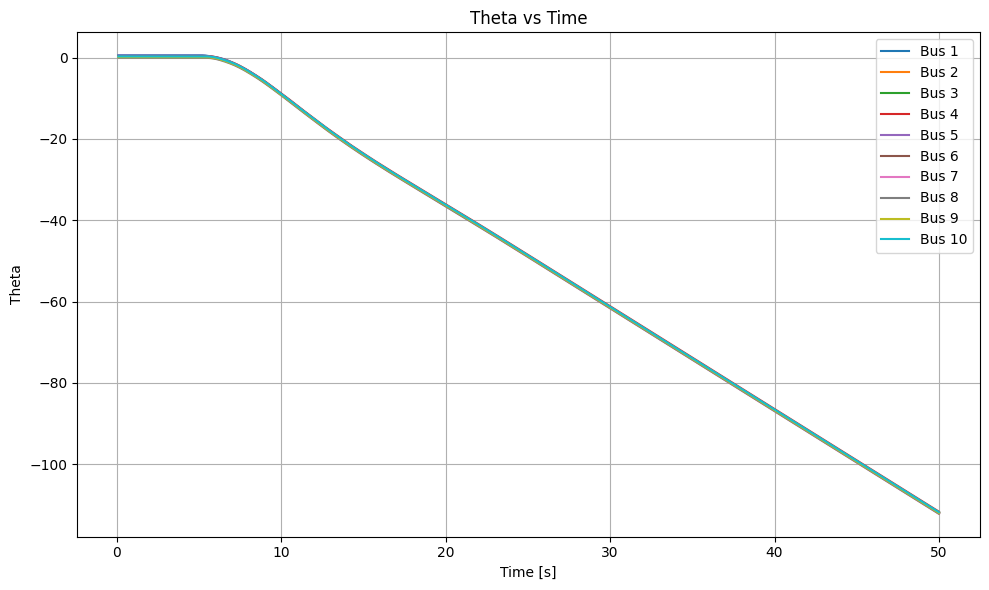

In [80]:
# Plot
plt.figure(figsize=(10, 6))
for i, theta in enumerate(theta_history):
    plt.plot(time_history, theta, label=f'Bus {i+1}')
plt.xlabel("Time [s]")
plt.ylabel("Theta")
plt.title("Theta vs Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

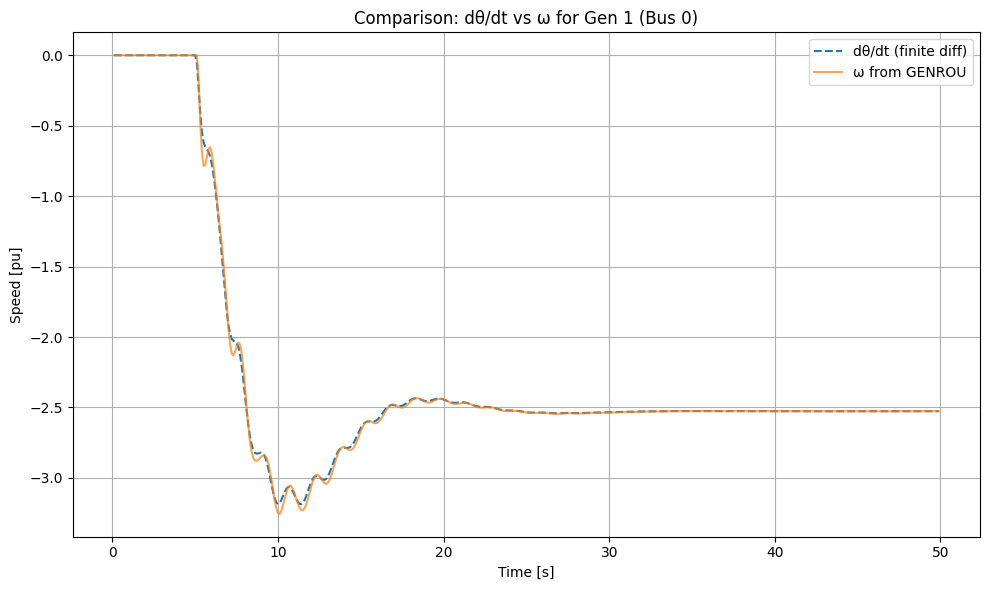

In [81]:
gen_idx = 0  # Choose which generator/bus to analyze
bus_idx = 0  # Index of bus connected to the generator
dt = tds.config.tstep

# Finite difference of theta
dtheta_dt = [(theta_history[bus_idx][i+1] - theta_history[bus_idx][i]) / dt for i in range(len(theta_history[bus_idx]) - 1)]
omega_trimmed = (np.array(omega_history[gen_idx][:-1]) - 1) * (2 * np.pi * 60)  # rad/s

# Plot
plt.figure(figsize=(10, 6))
plt.plot(time_history[:-1], dtheta_dt, label='dθ/dt (finite diff)', linestyle='--')
plt.plot(time_history[:-1], omega_trimmed, label='ω from GENROU', alpha=0.7)
plt.xlabel("Time [s]")
plt.ylabel("Speed [pu]")
plt.title(f"Comparison: dθ/dt vs ω for Gen {gen_idx+1} (Bus {bus_idx})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

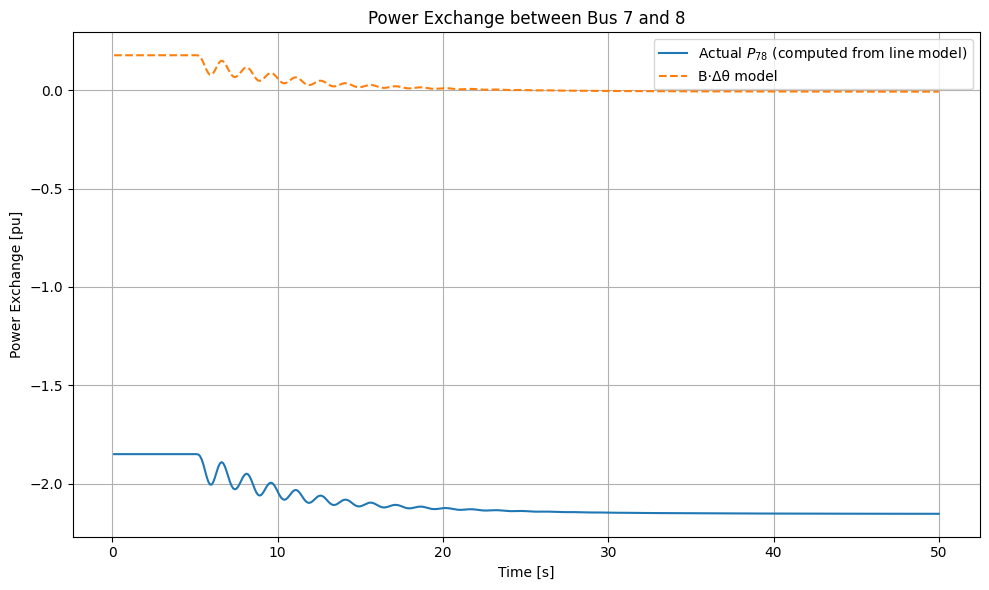

In [82]:
# Indices of the three lines between bus 7 and 8
line_idxs = [4, 5, 6]  # Adjust if necessary depending on actual line list order
bus7_idx = 6  # Bus 7 (zero-based index)
bus8_idx = 7  # Bus 8 (zero-based index)

pex_total = []
pex_model = []
B_total = sum([system.Line.b.v[i] for i in line_idxs])  # susceptance sum, for theta model

for t in range(len(time_history)):
    pex_sum = 0.0

    for i in line_idxs:
        # Bus indices
        bus1_idx = system.Line.bus1.v[i]
        bus2_idx = system.Line.bus2.v[i]

        # Voltages and angles at time t
        v1 = v_history[bus1_idx][t]
        v2 = v_history[bus2_idx][t]
        a1 = theta_history[bus1_idx][t]
        a2 = theta_history[bus2_idx][t]

        # Line parameters
        gh = system.Line.gh.v[i]
        ghk = system.Line.ghk.v[i]
        bhk = system.Line.bhk.v[i]
        tap = system.Line.tap.v[i]
        phi = system.Line.phi.v[i]
        u = system.Line.u.v[i]

        itap = 1 / tap
        itap2 = itap ** 2

        # Compute power flow from bus1 to bus2
        P_ij = u * (
            v1**2 * (gh + ghk) * itap2 -
            v1 * v2 * (ghk * np.cos(a1 - a2 - phi) + bhk * np.sin(a1 - a2 - phi)) * itap
        )

        pex_sum += P_ij

    pex_total.append(pex_sum)

    # B·Δθ model
    theta7 = theta_history[bus7_idx][t]
    theta8 = theta_history[bus8_idx][t]
    p_model = B_total * (theta7 - theta8)
    pex_model.append(p_model)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_history, pex_total, label="Actual $P_{78}$ (computed from line model)")
plt.plot(time_history, pex_model, '--', label="B·Δθ model")
plt.xlabel("Time [s]")
plt.ylabel("Power Exchange [pu]")
plt.title("Power Exchange between Bus 7 and 8")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


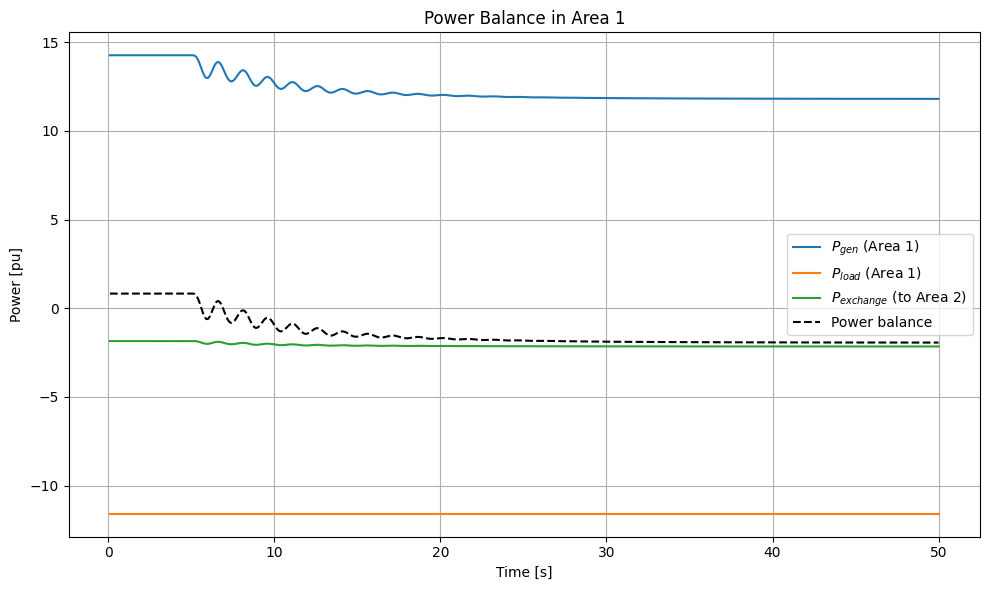

In [83]:
# Generator and load indices for Area 1
gen_area1_idxs = [0, 1]  # Gen 1 and 2
load_area1_idxs = [0]    # PQ load index in Area 1

# Inter-area line indices (between Bus 7 and 8)
line_idxs = [4, 5, 6]

# Initialize
pex_total = []
p_gen_total = []
p_load_total = []
p_balance = []

for t in range(len(time_history)):
    ### --- 1. Generator power in Area 1 ---
    p_gen = sum(Pe_history[i][t] for i in gen_area1_idxs)
    p_gen_total.append(p_gen)

    ### --- 2. Load power in Area 1 ---
    # Note: system.PQ.p.v[i] is positive, but it *consumes* power (should be negative in balance)
    p_load = -11.59
    p_load_total.append(p_load)

    ### --- 3. Power exchange through inter-area lines ---
    pex_sum = 0.0
    for i in line_idxs:
        bus1_idx = system.Line.bus1.v[i]
        bus2_idx = system.Line.bus2.v[i]
        v1 = v_history[bus1_idx][t]
        v2 = v_history[bus2_idx][t]
        a1 = theta_history[bus1_idx][t]
        a2 = theta_history[bus2_idx][t]

        gh = system.Line.gh.v[i]
        ghk = system.Line.ghk.v[i]
        bhk = system.Line.bhk.v[i]
        tap = system.Line.tap.v[i]
        phi = system.Line.phi.v[i]
        u = system.Line.u.v[i]

        itap = 1 / tap
        itap2 = itap ** 2

        # From-side power (P_ij)
        P_ij = u * (
            v1**2 * (gh + ghk) * itap2 -
            v1 * v2 * (ghk * np.cos(a1 - a2 - phi) + bhk * np.sin(a1 - a2 - phi)) * itap
        )
        pex_sum += P_ij
    pex_total.append(pex_sum)

    ### --- 4. Power balance ---
    balance = p_gen + p_load + pex_sum
    p_balance.append(balance)

# --- Plot results ---
plt.figure(figsize=(10, 6))
plt.plot(time_history, p_gen_total, label="$P_{gen}$ (Area 1)")
plt.plot(time_history, p_load_total, label="$P_{load}$ (Area 1)")
plt.plot(time_history, pex_total, label="$P_{exchange}$ (to Area 2)")
plt.plot(time_history, p_balance, '--k', label="Power balance")
plt.xlabel("Time [s]")
plt.ylabel("Power [pu]")
plt.title("Power Balance in Area 1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
